In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from matplotlib import pyplot
import datetime

Using TensorFlow backend.


In [15]:
r_dir = r'../raw_data/'
c_dir = r'../cleaned_data/'

In [70]:
Features = pd.read_csv(c_dir+"TS_2018.csv")
Features['tpep_pickup_datetime'] = pd.to_datetime(Features['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')

In [71]:
# Excluding DOM 
Features = Features.drop(['DOM'],axis =1 )

In [72]:
# exculde redundent axis
Features = Features.iloc[:,1:]

In [73]:
Features[Features['date']=='2018-11-01'].head(1)

,tpep_pickup_datetime,DOW,HOD,bad_weather,date,is_holiday,lag1,lag2,lag3,lag4,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
2213,2018-11-01,3,0,0,2018-11-01,0,577,726,608,494,...,300,207,142,68,66,92,125,199,371,358


In [74]:
Features[Features['date']=='2018-12-01'].head(1)

,tpep_pickup_datetime,DOW,HOD,bad_weather,date,is_holiday,lag1,lag2,lag3,lag4,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
2933,2018-12-01,5,0,0,2018-12-01,0,629,607,669,561,...,342,226,158,122,117,95,180,276,594,612


In [21]:
# Keep the timeline information
train_time = Features['tpep_pickup_datetime'].iloc[0:2213]
valid_time = Features['tpep_pickup_datetime'].iloc[2213:2933]
trainopt_time = Features['tpep_pickup_datetime'].iloc[0:2933]
test_time = Features['tpep_pickup_datetime'].iloc[2933:]

In [75]:
test_time_1 = Features['tpep_pickup_datetime'].iloc[2933:2957]

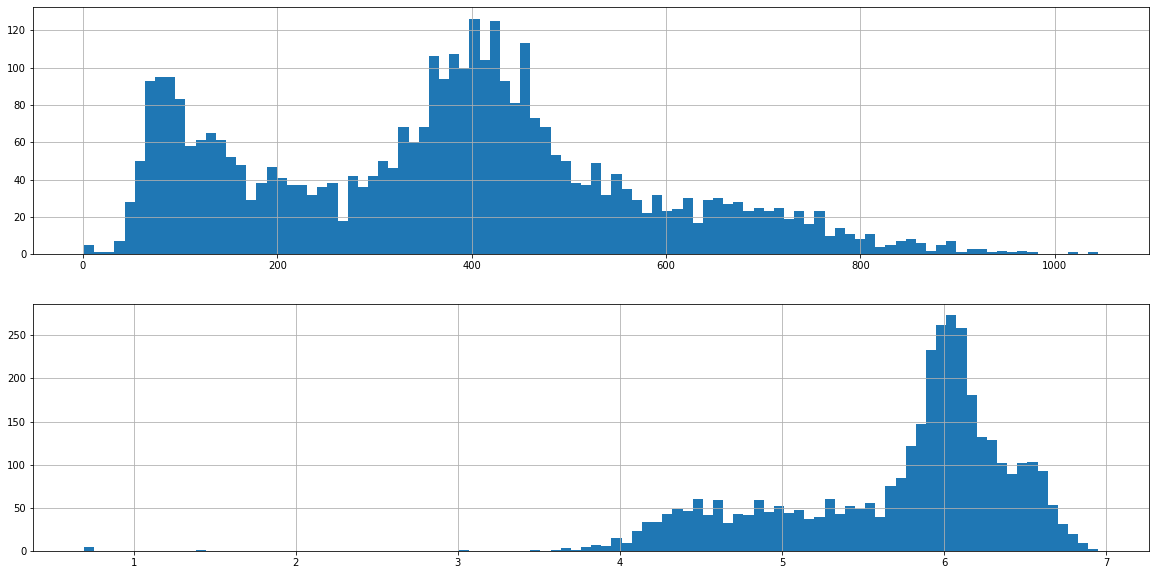

In [22]:
df = Features.copy()
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
df['trip_count'].hist(bins=100, ax=axes[0])
df['trip_count'] = np.log1p(df['trip_count'])
df['trip_count'].hist(bins=100, ax=axes[1])
plt.show()

In [23]:
# Prepare Feature for train-validation-test split
Features = Features.drop(['date','tpep_pickup_datetime'],axis=1)

In [24]:
Features.head()

,DOW,HOD,bad_weather,is_holiday,lag1,lag2,lag3,lag4,lag5,lag6,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,0,0,0,0,416,401,479,434,523,635,...,267,146,82,97,184,146,207,324,491,273
1,0,1,0,0,273,416,401,479,434,523,...,428,267,146,82,97,184,146,207,324,147
2,0,2,0,0,147,273,416,401,479,434,...,470,428,267,146,82,97,184,146,207,83
3,0,3,0,0,83,147,273,416,401,479,...,550,470,428,267,146,82,97,184,146,76
4,0,4,0,0,76,83,147,273,416,401,...,495,550,470,428,267,146,82,97,184,73


# Feature Engineering

In [25]:
# Feature splitting with scaler encoding only

In [26]:
train_df_s = Features.iloc[0:2213]
train_dfx_s = train_df_s.drop(['trip_count'],axis=1)
train_dfy_s = train_df_s.trip_count

valid_df_s = Features.iloc[2213:2933]
valid_dfx_s = valid_df_s.drop(['trip_count'],axis=1)
valid_dfy_s = valid_df_s.trip_count

train_opt_df_s = Features.iloc[0:2933]
train_opt_dfx_s = train_opt_df_s.drop(['trip_count'],axis=1)
train_opt_dfy_s = train_opt_df_s.trip_count

test_df_s = Features.iloc[2933:]
test_dfx_s = test_df_s.drop(['trip_count'],axis=1)
test_dfy_s = test_df_s.trip_count

In [27]:
# One hot encoding 
cat_columns = ['DOW','HOD']
Features_o =  pd.get_dummies(Features,prefix_sep="__",columns=cat_columns)
Features_o.shape

(3677, 58)

In [28]:
# Train validation test split


train_df_o = Features_o.iloc[0:2213]
train_dfx_o = train_df_o.drop(['trip_count'],axis=1)
train_dfy_o = train_df_o.trip_count

valid_df_o = Features_o.iloc[2213:2933]
valid_dfx_o = valid_df_o.drop(['trip_count'],axis=1)
valid_dfy_o = valid_df_o.trip_count

train_opt_df_o = Features_o.iloc[0:2933]
train_opt_dfx_o = train_opt_df_o.drop(['trip_count'],axis=1)
train_opt_dfy_o = train_opt_df_o.trip_count

test_df_o = Features_o.iloc[2933:]
test_dfx_o = test_df_o.drop(['trip_count'],axis=1)
test_dfy_o = test_df_o.trip_count

In [29]:
# create first order difference and scaled dataset
# scaled first then minus lag1
# inverse add back scaled lag1 and scale back

In [30]:
# switch between one-hot and scaler by switching between Features and Features_o 
scaler = MinMaxScaler()
df = Features_o

scaler_tripcount = MinMaxScaler()
scaler_tripcount.fit_transform(np.array(df.trip_count).reshape(-1,1))
# 
df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)


train_df_scaled = df.iloc[0:2213]
train_dfx_scaled = train_df_scaled.drop(['trip_count'],axis=1)
train_dfy_scaled = train_df_scaled.trip_count-train_df_scaled.lag1

valid_df_scaled = df.iloc[2213:2933]
valid_dfx_scaled = valid_df_scaled.drop(['trip_count'],axis=1)
valid_dfy_scaled = valid_df_scaled.trip_count-valid_df_scaled.lag1

train_opt_df_scaled = df.iloc[0:2933]
train_opt_dfx_scaled = train_opt_df_scaled.drop(['trip_count'],axis=1)
train_opt_dfy_scaled = train_opt_df_scaled.trip_count-train_opt_df_scaled.lag1

test_df_scaled = df.iloc[2933:]
test_dfx_scaled = test_df_scaled.drop(['trip_count'],axis=1)
test_dfy_scaled = test_df_scaled.trip_count-test_df_scaled.lag1


In [94]:
Features_o.head()

,bad_weather,is_holiday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,HOD__14,HOD__15,HOD__16,HOD__17,HOD__18,HOD__19,HOD__20,HOD__21,HOD__22,HOD__23
0,0,0,416,401,479,434,523,635,679,504,...,0,0,0,0,0,0,0,0,0,0
1,0,0,273,416,401,479,434,523,635,679,...,0,0,0,0,0,0,0,0,0,0
2,0,0,147,273,416,401,479,434,523,635,...,0,0,0,0,0,0,0,0,0,0
3,0,0,83,147,273,416,401,479,434,523,...,0,0,0,0,0,0,0,0,0,0
4,0,0,76,83,147,273,416,401,479,434,...,0,0,0,0,0,0,0,0,0,0


In [31]:
important_features = ['DOW','HOD','lag1','lag16','lag17','lag22','lag23','lag24']
#LR_important = ['bad_weather','is_holiday','HOD__0','HOD__1','HOD__7','HOD__8','HOD__9','HOD__11','HOD__12','HOD__21','HOD__23']
Selected = Features[important_features]


s_train_dfx = Selected.iloc[0:2213]
s_train_dfy = Features.trip_count[0:2213]

s_valid_dfx = Selected.iloc[2213:2933]
s_valid_dfy = Features.trip_count[2213:2933]

s_train_opt_dfx = Selected.iloc[0:2933]
s_train_opt_dfy = Features.trip_count[0:2933]

s_test_dfx = Selected.iloc[2933:]
s_test_dfy = Features.trip_count[2933:]



In [20]:
# Walk-forward Validation, incorporate new data as it becomes available, pass in dataframes
def walkforward_validation(model,trainx,trainy,testx,testy):
    tx = np.array(trainx)
    ty = np.array(trainy)
    tsx = np.array(testx)
    tsy = np.array(testy)
    
    predictions = []
    Actual = [tsy[i] for i in range(len(tsy))]
    Historyx = tx
    Historyy = ty
    
    for i in range(len(tsy)):
        model.fit(Historyx,Historyy)
        predictions.append(model.predict(tsx[i].reshape(1,-1)))
        np.append(Historyx,tsx[i])
        np.append(Historyy,tsy[i])
        if i%100 == 0:
            print (i)
    print ('Walkforward RMESE is',np.sqrt(mean_squared_error(predictions,Actual)) )
    return predictions

# Persistence model baseline

In [50]:
# walk-forward validation
predictions = test_df_s.lag1
test_score = np.sqrt(mean_squared_error(predictions, test_df_s.trip_count))
print('Test RMSE for baseline is : %.3f' % test_score)

Test RMSE for baseline is : 91.277


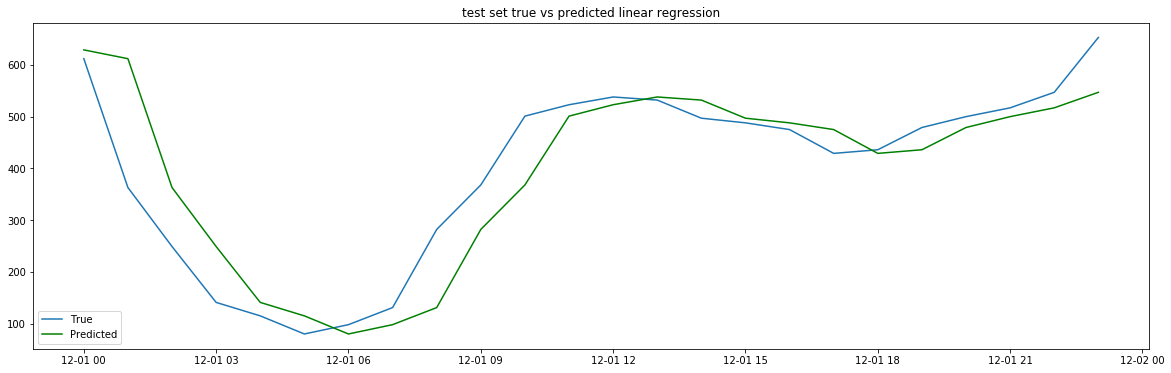

In [77]:
lmy = predictions[0:24]
plt.figure(figsize=(20,6))
plt.plot(test_time_1,test_dfy_o[0:24],label='True')
plt.plot(test_time_1,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

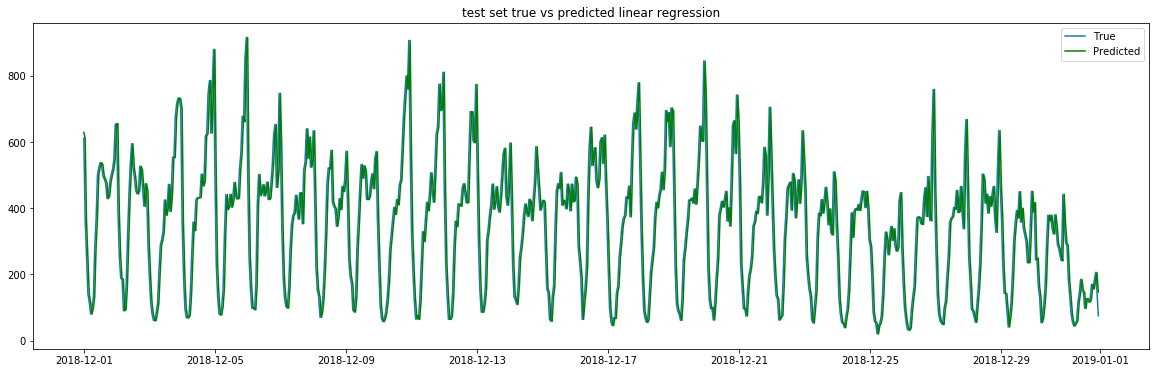

In [81]:
lmy = predictions
plt.figure(figsize=(20,6))
plt.plot(test_time,test_dfy_o,label='True')
plt.plot(test_time,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

# linear regression

In [ ]:
# regularization not very useful in this case
reg_lasso =  linear_model.Lasso(alpha=0.1).fit(train_dfx,train_dfy)
print('in_sample R2',reg_lasso.score(train_dfx,train_dfy))
print('Out_sample R2',reg_lasso.score(valid_dfx,valid_dfy))

In [8]:
# Normal Linear regression , flag 0 use normal data, flag 1 use scaled and differenced data, flag2 use selected Features
# Return validation, test, best test result
def Regression_result(model,flag):
    if flag == 0:
        x =  train_dfx_o
        y =  train_dfy_o
        ox = train_opt_dfx_o
        oy = train_opt_dfy_o
        vx = valid_dfx_o
        vy = valid_dfy_o
        tx = test_dfx_o
        ty = test_dfy_o
    if flag == 1:
        x =  train_dfx_scaled
        y =  train_dfy_scaled
        ox = train_opt_dfx_scaled
        oy = train_opt_dfy_scaled
        vx = valid_dfx_scaled
        vy = valid_dfy_scaled
        tx = test_dfx_scaled
        ty = test_dfy_scaled
    if flag == 2:
        x =  s_train_dfx
        y =  s_train_dfy
        ox = s_train_opt_dfx
        oy = s_train_opt_dfy
        vx = s_valid_dfx
        vy = s_valid_dfy
        tx = s_test_dfx
        ty = s_test_dfy
        
    reg = model.fit(x,y)
    

    lmy_train = reg.predict(x)
    lmy_valid = reg.predict(vx)
    lmy_test = reg.predict(tx)
    
    reg1 = model.fit(ox,oy)
    lmy_test2 = reg1.predict(tx)

    # scale back
    if flag == 1:
        lmy_train = lmy_train + x.lag1.tolist()  
        lmy_train = scaler_tripcount.inverse_transform(lmy_train.reshape(-1,1))
        lmy_valid = lmy_valid + vx.lag1.tolist()  
        lmy_valid = scaler_tripcount.inverse_transform(lmy_valid.reshape(-1,1))
        lmy_test = lmy_test + tx.lag1.tolist()  
        lmy_test = scaler_tripcount.inverse_transform(lmy_test.reshape(-1,1))
        lmy_test2 = lmy_test2 + tx.lag1.tolist()  
        lmy_test2 = scaler_tripcount.inverse_transform(lmy_test2.reshape(-1,1))
        
    # here use external global information train_dfy_o, should modify if have time
    # rerun that data every time to use
    RMSE_tr = np.sqrt(mean_squared_error(train_dfy_o,lmy_train))
    RMSE_va = np.sqrt(mean_squared_error(valid_dfy_o,lmy_valid))
    RMSE_te = np.sqrt(mean_squared_error(test_dfy_o,lmy_test))
    RMSE_te_best = np.sqrt(mean_squared_error(test_dfy_o,lmy_test2))

    print('The training RMSE is',RMSE_tr)
    print('The validation RMSE is',RMSE_va)
    print('The test RMSE is',RMSE_te)
    print('The walk-forward test RMSE is',RMSE_te_best)
    return [lmy_valid, lmy_test,lmy_test2]

In [35]:
results = Regression_result(linear_model.Lasso(alpha=0.4),0)

The training RMSE is 55.952648621841945
The validation RMSE is 66.59752160635763
The test RMSE is 60.57829962736106
The walk-forward test RMSE is 60.587691765154844


In [36]:
# normal regression
results = Regression_result(linear_model.Lasso(alpha=0.4),0)

The training RMSE is 55.952648621841945
The validation RMSE is 66.59752160635763
The test RMSE is 60.57829962736106
The walk-forward test RMSE is 60.587691765154844


In [47]:
# Regression with scaled and transformed
results = Regression_result(LinearRegression(),1)

The training RMSE is 53.771187061778924
The validation RMSE is 65.62636261152244
The test RMSE is 63.11847893983024
The walk-forward test RMSE is 62.624469031558846


In [98]:
# Linear regression with Selected Features
results = Regression_result(LinearRegression(),2)

The training RMSE is 65.92616767751008
The validation RMSE is 77.48138365417292
The test RMSE is 68.36508088976795
The walk-forward test RMSE is 68.19518795071285


# Linear Regression Optimal

In [66]:
# Linear regression with scaled and differenced data
results = Regression_result(LinearRegression(),1)

The training RMSE is 53.771187061778924
The validation RMSE is 65.62636261152244
The test RMSE is 63.11847893983024
The walk-forward test RMSE is 62.624469031558846


In [ ]:
LR_important = ['bad_weather','is_holiday','HOD_0','HOD_1','HOD_7','HOD_8','HOD_9','HOD_11','HOD_12','HOD_21','HOD_23']

In [92]:
important = Features_o[LR_important]

,bad_weather,is_holiday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,HOD__14,HOD__15,HOD__16,HOD__17,HOD__18,HOD__19,HOD__20,HOD__21,HOD__22,HOD__23
0,0,0,416,401,479,434,523,635,679,504,...,0,0,0,0,0,0,0,0,0,0
1,0,0,273,416,401,479,434,523,635,679,...,0,0,0,0,0,0,0,0,0,0
2,0,0,147,273,416,401,479,434,523,635,...,0,0,0,0,0,0,0,0,0,0
3,0,0,83,147,273,416,401,479,434,523,...,0,0,0,0,0,0,0,0,0,0
4,0,0,76,83,147,273,416,401,479,434,...,0,0,0,0,0,0,0,0,0,0


In [59]:
#predicted = walkforward_validation(LinearRegression(),train_opt_dfx,train_opt_dfy,test_dfx,test_dfy)

0
100
200
300
400
500
600
700
Walkforward RMESE is 61.70596062928227


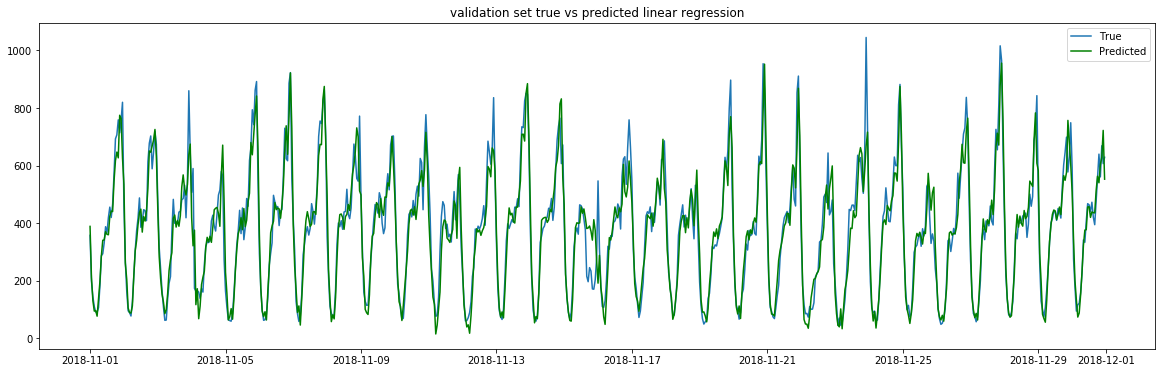

In [184]:
lmy = results[0]
plt.figure(figsize=(20,6))
plt.plot(valid_time,valid_dfy_o,label='True')
plt.plot(valid_time,lmy, color='green',label='Predicted')
plt.title('validation set true vs predicted linear regression')
plt.legend()
plt.show()

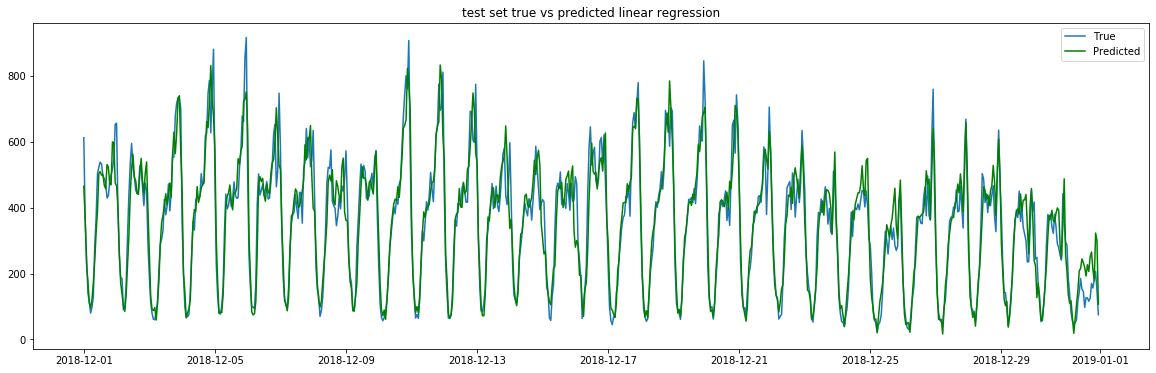

In [69]:
lmy =  results[2]
plt.figure(figsize=(20,6))
plt.plot(test_time,test_dfy_o,label='True')
plt.plot(test_time,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

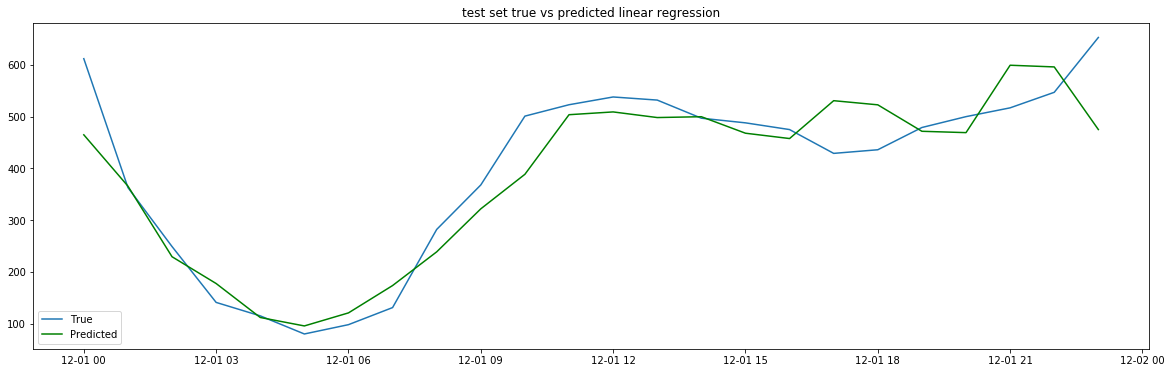

In [78]:
lmy = results[2][0:24]
plt.figure(figsize=(20,6))
plt.plot(test_time_1,test_dfy_o[0:24],label='True')
plt.plot(test_time_1,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

In [ ]:
# Different splits: Train test, Multiple Train test , Walk forward Validation

# Random Forest

In [82]:
# Random Forest could handle scaler encoded data directly 
regrf = RandomForestRegressor(n_estimators=100,max_depth=30, max_features=16, bootstrap=True,oob_score=True).fit(train_dfx_s,train_dfy_s)
train_predict = regrf.predict(train_dfx_s)
valid_predict = regrf.predict(valid_dfx_s)
test_predict = regrf.predict(test_dfx_s)

Train_RMSE = np.sqrt(mean_squared_error(train_predict,train_dfy_s))
Valid_RMSE = np.sqrt(mean_squared_error(valid_predict,valid_dfy_s))   
Test_RMSE = np.sqrt(mean_squared_error(test_predict,test_dfy_s))

print('in_sample R2',regrf.score(train_dfx_s,train_dfy_s))
print('Out_sample R2',regrf.score(valid_dfx_s,valid_dfy_s))
print('train RMSE',Train_RMSE)
print('Validation RMSE',Valid_RMSE)
print('Test RMSE',Test_RMSE)

in_sample R2 0.9910368992174337
Out_sample R2 0.9015479632093295
train RMSE 18.897147069719402
Validation RMSE 65.49368680771198
Test RMSE 61.71920992519527


In [83]:
# feature importance

print(regrf.feature_importances_)
# plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize = (30,8))
plt.bar(train_dfx_s.columns, regrf.feature_importances_)
plt.show()

AttributeError: 'RandomForestRegressor' object has no attribute 'get_booster'

In [57]:
# Normal Random Forest
regrf = RandomForestRegressor(n_estimators=500,max_depth=30, max_features=16, bootstrap=True,oob_score=True)
rfresults = Regression_result(regrf,0)


The training RMSE is 18.413219023915357
The validation RMSE is 68.32354802185951
The test RMSE is 62.511262687245946
The walk-forward test RMSE is 61.035791915633354


In [56]:
# Scaled and Transformed Random Forest
regrf = RandomForestRegressor(n_estimators=500,max_depth=30, max_features=16, bootstrap=True,oob_score=True)
rfresults = Regression_result(regrf,1)

The training RMSE is 18.868537733946372
The validation RMSE is 62.556987622678314
The test RMSE is 61.61407925316493
The walk-forward test RMSE is 59.47207961831862


In [ ]:
# Random Forest parameter tuning number of trees and maximum number of features to find lowest validation RMSE
# test number of tree from 100 to 500 with step 10
# test max features from 10 to 29
n_tree=[int(i) for i in range(100,501,10)]
max_features=[int(i) for i in range(10,30)]
optimal_param = np.zeros(2)
valid_RMSE_list = []
min_RMSE = 1000

for j in max_features:
    for i in n_tree:
        regr=RandomForestRegressor(n_estimators=i,max_features=j,bootstrap=True,oob_score=True,n_jobs=-1)
        regr.fit(train_dfx_s,train_dfy_s) 
        valid_predict = regr.predict(valid_dfx_s)
        valid_RMSE = np.sqrt(mean_squared_error(valid_predict,valid_dfy_s))
        valid_RMSE_list.append(valid_RMSE)
        if valid_RMSE < min_RMSE:
            min_RMSE = valid_RMSE
            optimal_param[0] = j
            optimal_param[1] = i
        if i%20==0:
            print(j,'and',i,'epochs')

In [213]:
print('lowest valid RMSE is',min_RMSE,'with max_features',optimal_param[0],'and n_tress',optimal_param[1])

lowest valid RMSE is 70.05558346274447 with max_features 16.0 and n_tress 100.0


# Random Forest Optimal

In [17]:
# Do some feature selection to see if result improve

from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator = RandomForestRegressor(n_estimators=100, max_features=16, bootstrap=True,oob_score=True)).fit(train_opt_dfx_s,train_opt_dfy_s)
selector.threshold_

0.03448275862068965

# Random Forest Feature Selected

In [79]:
# selected data
regrf = RandomForestRegressor(n_estimators=300,max_depth=10, max_features=5, bootstrap=True,oob_score=True)
rfresults = Regression_result(regrf,2)

The training RMSE is 29.272109605980713
The validation RMSE is 65.39608235584883
The test RMSE is 60.920809006571396
The walk-forward test RMSE is 59.38744684770868


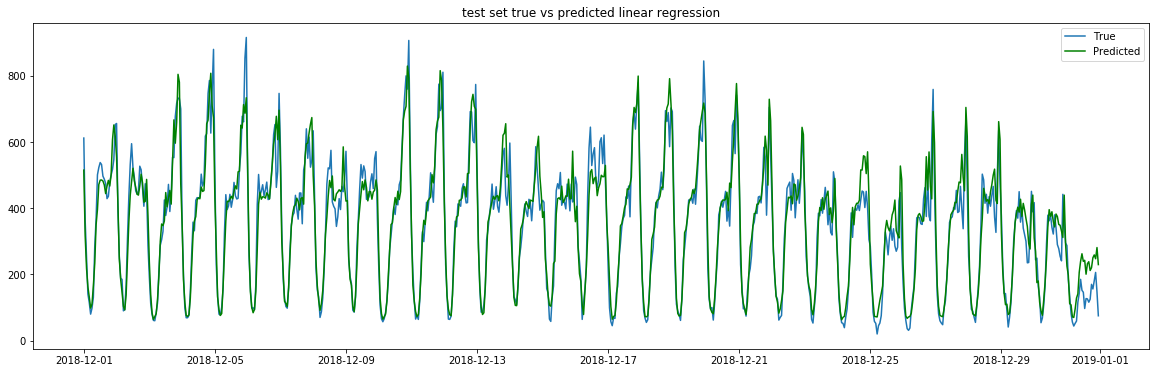

In [64]:
lmy =  rfresults[2]
plt.figure(figsize=(20,6))
plt.plot(test_time,test_dfy_o,label='True')
plt.plot(test_time,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

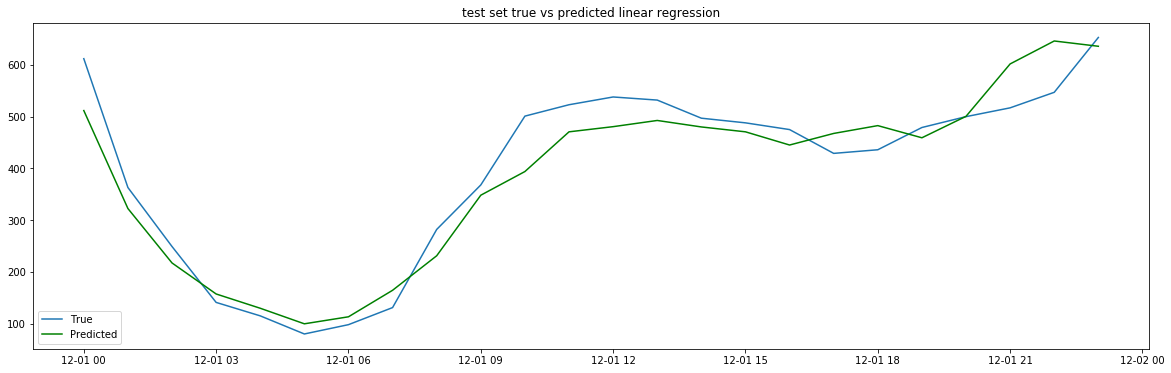

In [80]:
lmy = rfresults[2][0:24]
plt.figure(figsize=(20,6))
plt.plot(test_time_1,test_dfy_o[0:24],label='True')
plt.plot(test_time_1,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

In [40]:
# Experiment on scaled and differenced data
regrf = RandomForestRegressor(n_estimators=200,max_depth=10, max_features=16, bootstrap=True,oob_score=True)
rfresults = Regression_result(regrf,1)

The training RMSE is 33.295076901945855
The validation RMSE is 63.420653826192506
The test RMSE is 61.325750662518466
The walk-forward test RMSE is 60.11681828300607


# Optimal of all methods

In [58]:
regrf = RandomForestRegressor(n_estimators=400,max_depth=15, max_features=30, bootstrap=True,oob_score=True)
rfresults = Regression_result(regrf,0)

The training RMSE is 19.423333438258965
The validation RMSE is 65.55799256251979
The test RMSE is 59.6021848903055
The walk-forward test RMSE is 58.94901822611445


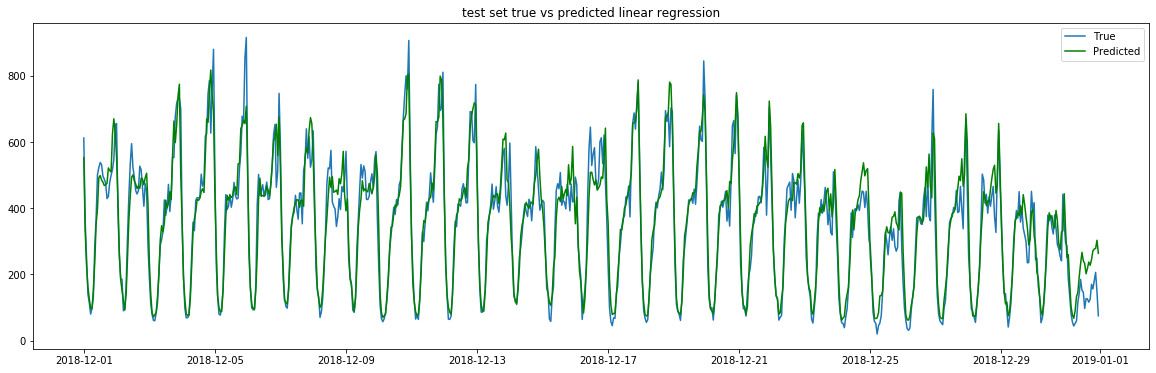

In [59]:
lmy =  rfresults[2]
plt.figure(figsize=(20,6))
plt.plot(test_time,test_dfy_o,label='True')
plt.plot(test_time,lmy, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

# Xgboost

In [87]:
# Xgboost 

xgb_model = xgb.XGBRegressor().fit(train_dfx_o,train_dfy_o)
Xgboost_train_predict = xgb_model.predict(train_dfx_o)
Xgboost_valid_predict = xgb_model.predict(valid_dfx_o)

Train_RMSE = np.sqrt(mean_squared_error(train_dfy_o, Xgboost_train_predict))
Valid_RMSE = np.sqrt(mean_squared_error(valid_dfy_o, Xgboost_valid_predict) )   
            
print('in_sample R2',r2_score(train_dfy_o, Xgboost_train_predict))
print('Out_sample R2',r2_score(valid_dfy_o, Xgboost_valid_predict))
print('train RMSE',Train_RMSE)
print('Validation RMSE',Valid_RMSE)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:07:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
in_sample R2 0.9587380357668939
Out_sample R2 0.9011980883764187
train RMSE 40.5454432262944
Validation RMSE 65.60995799585898


In [ ]:
n_tree=[int(i) for i in range(100,501,50)]
max_depth=[int(i) for i in range(5,11)]
optimal_param_xgb = np.zeros(3)
valid_RMSE_list_xgb = []
min_RMSE_xgb = 1000

for i in max_depth:
    for j in n_tree:
        for k in learning_rate:
            regr=xgb.XGBRegressor(n_estimators=j,max_depth=i,learning_rate = k, n_jobs=-1)
            regr.fit(train_dfx_s,train_dfy_s) 
            valid_predict = regr.predict(valid_dfx_s)
            valid_RMSE = np.sqrt(mean_squared_error(valid_predict,valid_dfy_s))
            valid_RMSE_list_xgb.append(valid_RMSE)
            if valid_RMSE < min_RMSE_xgb:
                min_RMSE_xgb = valid_RMSE
                optimal_param_xgb[0] = i
                optimal_param_xgb[1] = j
                optimal_param_xgb[2] = k
            print(j,'and',i,'epochs')

[9.70071196e-05 3.43521079e-03 2.40148813e-01 2.88149714e-03
 2.57779304e-02 9.87107027e-03 4.46457230e-03 7.26199988e-03
 4.23350511e-03 7.03113014e-03 2.01327843e-03 2.54587783e-03
 4.18039225e-03 3.26754339e-03 3.82791413e-03 5.00881113e-03
 1.45283742e-02 7.62397349e-02 4.81707267e-02 3.37836426e-03
 7.40242517e-03 4.07496188e-03 4.94526140e-03 3.46950628e-02
 1.04980908e-01 1.97686121e-01 0.00000000e+00 4.89113899e-03
 2.81127961e-03 6.60126563e-03 6.88350573e-03 3.85643239e-03
 2.05495134e-02 6.84416816e-02 9.28109977e-03 0.00000000e+00
 0.00000000e+00 1.70700380e-03 2.90692877e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.28329794e-03
 2.23747874e-03 0.00000000e+00 6.37320383e-03 6.16012421e-03
 1.40729221e-03 7.73838628e-03 4.96453373e-03 1.26334205e-02
 6.12401497e-03]


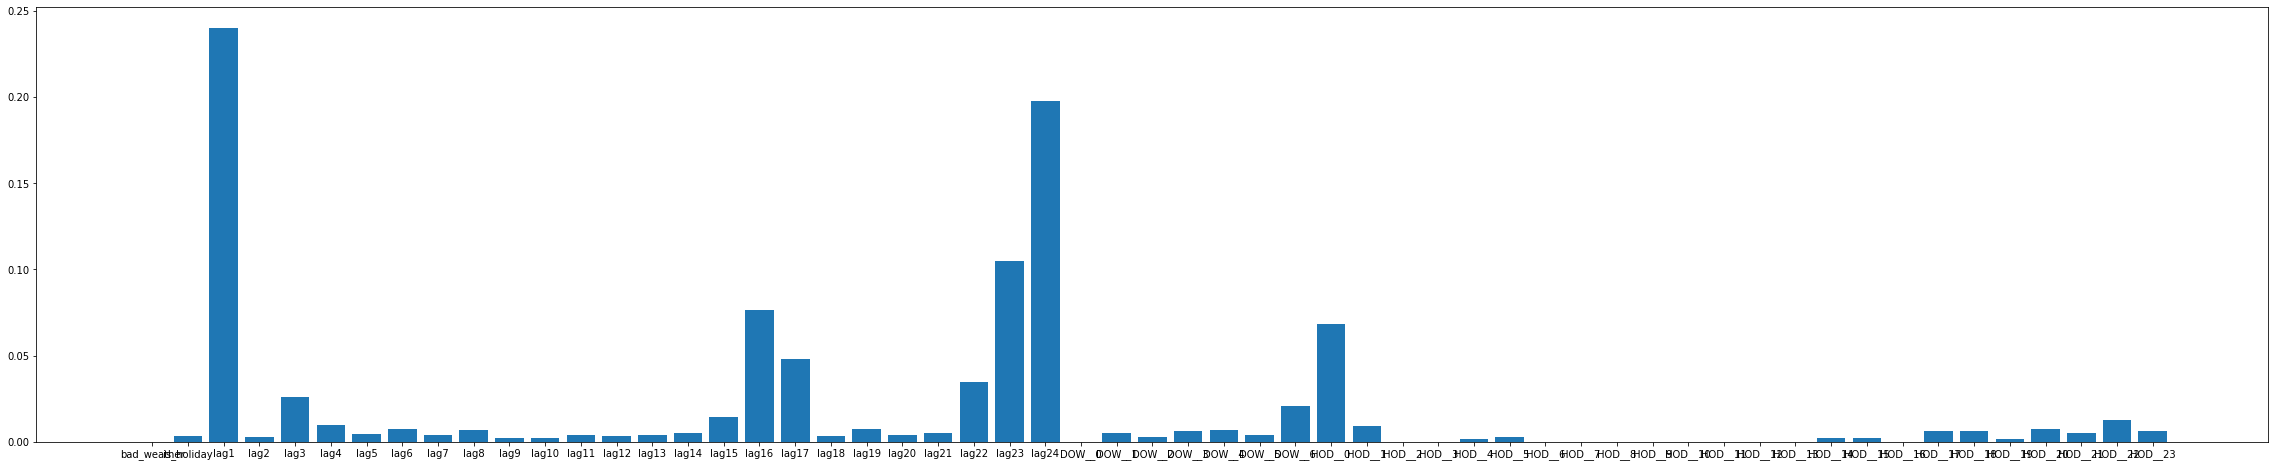

In [89]:
# feature importance
#xgb_model.get_booster().get_score(importance_type='gain')
print(xgb_model.feature_importances_)
# plot
plt.figure(figsize = (40,8))
plt.bar(train_dfx_o.columns, xgb_model.feature_importances_)
plt.show()

In [249]:
print('lowest valid RMSE is',min_RMSE_xgb ,'with max_depth',optimal_param_xgb[0],'n_estimators',optimal_param_xgb[1],'and learning rate',optimal_param_xgb[2])

lowest valid RMSE is 64.86716820856458 with max_depth 7.0 n_estimators 300.0 and learning rate 0.1


In [73]:
# scaled
xgbmodel = xgb.XGBRegressor(n_estimators=300,max_depth=5,learning_rate = 0.1, n_jobs=-1)
xgbresults = Regression_result(xgbmodel,1)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:06:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The training RMSE is 13.632995067634488
The validation RMSE is 60.774585659308265
The test RMSE is 61.820159861144965
The walk-forward test RMSE is 57.78394326640466


In [83]:
xgbmodel = xgb.XGBRegressor(n_estimators=50,max_depth=4,learning_rate = 0.1, n_jobs=-1)
xgbresults = Regression_result(xgbmodel,2)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:08:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:08:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The training RMSE is 41.453233719880906
The validation RMSE is 63.877474350281425
The test RMSE is 59.11018036449705
The walk-forward test RMSE is 58.07360417711309


# Xgboost Optimal 

In [62]:
# normal data with optimal parameters
xgbmodel = xgb.XGBRegressor(n_estimators=100,max_depth=5,learning_rate = 0.1, n_jobs=-1)
xgbresults = Regression_result(xgbmodel,0)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:04:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The training RMSE is 25.372804685178924
The validation RMSE is 61.7984246077216
The test RMSE is 59.159525572972605
The walk-forward test RMSE is 58.47190197735767
